<a href="https://colab.research.google.com/github/kevincong95/cs231n-emotiw/blob/master/notebooks/2.4-tj-la-ak-kc-vl-FINAL-ensemble_fc_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Video Sentiment Analysis in the Wild
### Ensembling Notebook | FC | CS231n

This notebook runs a basic FC classifier on the predicted outputs of each individual modality. Assumes the preprocessing has already been completed.

Contains:
- Frame
- Audio
- Pose


### Are we working with the tiny dataset or the final dataset?

In [0]:
IS_TINY = False

### Copy Pre-Processed Files

In [0]:
!ls

sample_data


In [0]:
!nvidia-smi

Sun Jun  7 11:40:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')
FULL_PATH = 'My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw'
#FULL_PATH = 'My Drive/cs231n-project/datasets/emotiw'
if IS_TINY:
    print("Using tiny dataset...")
    !cp /content/drive/'$FULL_PATH'/train-tiny-* .
    !cp /content/drive/'$FULL_PATH'/val-tiny-* .
else:
    print("Using final dataset...")
    !cp /content/drive/'$FULL_PATH'/train-final-* .
    !cp /content/drive/'$FULL_PATH'/val-final-* .

!wget https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
!wget https://storage.googleapis.com/cs231n-emotiw/data/Val_labels.txt


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Using final dataset...
--2020-06-07 11:44:53--  https://storage.googleapis.com/cs231n-emotiw/data/Train_labels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21653 (21K) [text/plain]
Saving to: ‘Train_labels.txt’

Train_labels.txt    100%[=================

In [0]:
!ls

drive		       train-final-frames.zip  val-final-fer.zip
sample_data	       train-final-pose.zip    val-final-frames.zip
train-final-audio.zip  Train_labels.txt        val-final-pose.zip
train-final-faces.zip  val-final-audio.zip     Val_labels.txt
train-final-fer.zip    val-final-faces.zip


In [0]:
# RUN THIS FOR TINY FILES (zip does not include root folder)

if IS_TINY:
    !unzip -d train-tiny-audio train-tiny-audio.zip
    !unzip -d train-tiny-faces train-tiny-faces.zip
    !unzip -d train-tiny-frames train-tiny-frames.zip
    !unzip -d train-tiny-pose train-tiny-pose.zip

    !unzip -d val-tiny-audio val-tiny-audio.zip
    !unzip -d val-tiny-faces val-tiny-faces.zip
    !unzip -d val-tiny-frames val-tiny-frames.zip
    !unzip -d val-tiny-pose val-tiny-pose.zip


# RUN THIS FOR FINAL FILES (zip includes root folder)

if not IS_TINY:
    !unzip train-final-audio.zip
    !unzip train-final-faces.zip
    !unzip train-final-frames.zip
    !unzip train-final-pose.zip
    !unzip -d train-final-fer train-final-fer.zip

    !unzip val-final-audio.zip
    !unzip val-final-faces.zip
    !unzip val-final-frames.zip
    !unzip val-final-pose.zip
    !unzip -d val-final-fer val-final-fer.zip



Streaming output truncated to the last 5000 lines.
  inflating: val-final-pose/1/frame_212_1.mp4_5_keypoints.json  
  inflating: val-final-pose/1/frame_289_57.mp4_3_keypoints.json  
  inflating: val-final-pose/1/frame_86_8.mp4_12_keypoints.json  
  inflating: val-final-pose/1/frame_54_3.mp4_0_keypoints.json  
  inflating: val-final-pose/1/frame_145_2.mp4_10_keypoints.json  
  inflating: val-final-pose/1/frame_289_42.mp4_4_keypoints.json  
  inflating: val-final-pose/1/frame_284_5.mp4_3_keypoints.json  
  inflating: val-final-pose/1/frame_289_53.mp4_7_keypoints.json  
  inflating: val-final-pose/1/frame_5_17.mp4_12_keypoints.json  
  inflating: val-final-pose/1/frame_5_15.mp4_1_keypoints.json  
  inflating: val-final-pose/1/frame_70_11.mp4_5_keypoints.json  
  inflating: val-final-pose/1/frame_44_4.mp4_4_keypoints.json  
  inflating: val-final-pose/1/frame_289_8.mp4_9_keypoints.json  
  inflating: val-final-pose/1/frame_5_7.mp4_7_keypoints.json  
  inflating: val-final-pose/1/frame_15_5

In [0]:
!ls

sample_data


### Run Classifiers

In [0]:
%tensorflow_version 2.x

In [0]:
import tensorflow
print(tensorflow.__version__)

2.2.0


In [0]:
!pwd

/content


In [0]:
!git clone 'https://github.com/kevincong95/cs231n-emotiw.git'

Cloning into 'cs231n-emotiw'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 922 (delta 140), reused 121 (delta 51), pack-reused 683
Receiving objects: 100% (922/922), 189.65 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (548/548), done.


In [0]:
!mv train-* cs231n-emotiw
!mv val-* cs231n-emotiw

In [0]:
!mv Train* cs231n-emotiw
!mv Val* cs231n-emotiw

In [0]:
!pwd

/content


In [0]:
import os
os.chdir('/content/cs231n-emotiw')
!pwd

/content/cs231n-emotiw


In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifier import FaceClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', face_folder='train-final-fer' , labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
    face_classifier = FaceClassifier(face_folder, model_location='/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5', is_test=False)
    classifiers = [audio_classifier, frames_classifier, pose_classifier] # face_classifier]
    
    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [0]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    "dense",
    "concatenate_5",
    "bidirectional_1",
    #"dense_27",
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose" ,labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose" , labels_file="Val_labels.txt")

print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Cu

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 2661
Dim shapes: 
[32, 30, 128]
2661
2661
2661
AudioClassifier created with audio_folder = val-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = val-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = val-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 766 frames belonging to 766 video

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Number of samples: 766
Dim shapes: 
[32, 30, 128]
766
766
766
(2661, 190)
(2661, 3)


In [0]:
!ls

 data					     train-final-frames
 LICENSE				     train-final-frames.zip
 models					     train-final-pose
 notebooks				     train-final-pose.zip
 README.md				     Train_labels.txt
 reports				     val-final-audio
 requirements-predictions.txt		     val-final-audio.zip
 requirements.txt			     val-final-faces
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-faces.zip
 src					     val-final-fer
 train-final-audio			     val-final-fer.zip
 train-final-audio.zip			     val-final-frames
 train-final-faces			     val-final-frames.zip
 train-final-faces.zip			     val-final-pose
 train-final-fer			     val-final-pose.zip
 train-final-fer.zip			     Val_labels.txt


In [0]:
# !mkdir ensemble-scene-pose-audio-face
# np.save("ensemble-scene-pose-audio-face/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face.zip ensemble-scene-pose-audio-face
# !cp ensemble-scene-pose-audio-face.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw

# !mkdir ensemble-scene-pose-audio-face-v2
# np.save("ensemble-scene-pose-audio-face-v2/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face-v2/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face-v2/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face-v2/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face-v2.zip ensemble-scene-pose-audio-face-v2
# !cp ensemble-scene-pose-audio-face-v2.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw


!mkdir ensemble-scene-pose-audio-v1
np.save("ensemble-scene-pose-audio-v1/X_train.npy", X_train)
np.save("ensemble-scene-pose-audio-v1/y_train.npy", y_train)
np.save("ensemble-scene-pose-audio-v1/X_valid.npy", X_valid)
np.save("ensemble-scene-pose-audio-v1/y_valid.npy", y_valid)
!zip -r ensemble-scene-pose-audio-v1.zip ensemble-scene-pose-audio-v1
!cp ensemble-scene-pose-audio-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw


mkdir: cannot create directory ‘ensemble-scene-pose-audio-v1’: File exists
  adding: ensemble-scene-pose-audio-v1/ (stored 0%)
  adding: ensemble-scene-pose-audio-v1/y_valid.npy (deflated 96%)
  adding: ensemble-scene-pose-audio-v1/X_valid.npy (deflated 46%)
  adding: ensemble-scene-pose-audio-v1/X_train.npy (deflated 46%)
  adding: ensemble-scene-pose-audio-v1/y_train.npy (deflated 97%)


## Remove the Face!

In [0]:
!ls

 data					     train-final-fer.zip
 ensemble-scene-pose-audio-v1		     train-final-frames
 ensemble-scene-pose-audio-v1.zip	     train-final-frames.zip
 LICENSE				     train-final-pose
 models					     train-final-pose.zip
 notebooks				     Train_labels.txt
 README.md				     val-final-audio
 reports				     val-final-audio.zip
 requirements-predictions.txt		     val-final-faces
 requirements.txt			     val-final-faces.zip
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-fer
 src					     val-final-fer.zip
 train-final-audio			     val-final-frames
 train-final-audio.zip			     val-final-frames.zip
 train-final-faces			     val-final-pose
 train-final-faces.zip			     val-final-pose.zip
 train-final-fer			     Val_labels.txt


In [0]:
#!rm -rf ensemble-scene-pose-audio
#!cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio.zip .
#!unzip ensemble-scene-pose-audio.zip

X_train = np.load("ensemble-scene-pose-audio-v1/X_train.npy")
y_train = np.load("ensemble-scene-pose-audio-v1/y_train.npy")
X_valid = np.load("ensemble-scene-pose-audio-v1/X_valid.npy")
y_valid = np.load("ensemble-scene-pose-audio-v1/y_valid.npy")
X_train.shape

(2661, 190)

In [0]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=919bfa89fd0bfebaf3f5382fea17304f64d70f504ad94ff4842c286421c21423
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=bf99681f101e98d650848379db8bb0e4ba9a99b524af57fad56a866af5d9d321
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

MODEL_NAME = "ensemble-scene-pose-audio-v1"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

def build_model(hp):
    Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
    checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1
    )

    def create_model(inputs):
        x = tf.keras.layers.Dense(hp.Int('units', min_value=8, max_value=128, step=8), activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                      loss = 'categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    inputs = tf.keras.Input(shape=(X_train.shape[1]))
    model = create_model(inputs)
    # model.summary()
    return model




In [0]:

from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='fc-prediction',
    project_name='fc-prediction'
)
tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_valid, y_valid),
             verbose=0)


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()

Epoch 1/30
81/84 [===========================>..] - ETA: 0s - loss: 0.5563 - accuracy: 0.7851
Epoch 00001: val_accuracy improved from -inf to 0.61358, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-pose-audio-v1/cp-0001.h5
84/84 [==============================] - 0s 5ms/step - loss: 0.5568 - accuracy: 0.7843 - val_loss: 0.9488 - val_accuracy: 0.6136
Epoch 2/30
65/84 [======================>.......] - ETA: 0s - loss: 0.4770 - accuracy: 0.8168
Epoch 00002: val_accuracy improved from 0.61358 to 0.62402, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-pose-audio-v1/cp-0002.h5
84/84 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.8174 - val_loss: 1.0231 - val_accuracy: 0.6240
Epoch 3/30
65/84 [======================>.......] - ETA: 0s - loss: 0.4772 - accuracy: 0.8231
Epoch 00003: val_accuracy did not improve from 0.62402
84/84 [==============================] - 0s 3ms/st

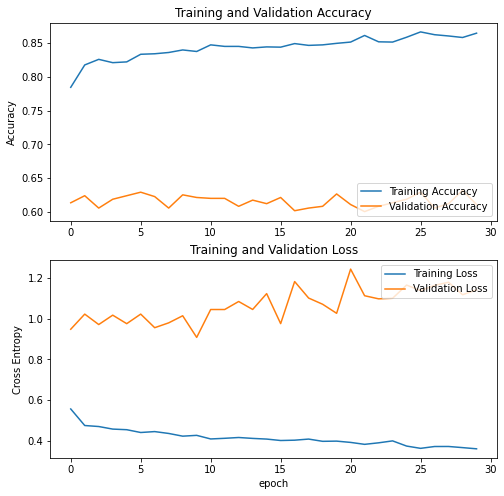

In [0]:

MODEL_NAME = "ensemble-scene-pose-audio-v1"
Path(f"drive/My Drive/Machine-Learning-Projects/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/Machine-Learning-Projects/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(72, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Load Best Model to Perform Prediction

In [0]:
model = tf.keras.models.load_model("drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-pose-audio-v1/cp-0029.h5")

y_pred = model.predict(X_valid)

In [0]:
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_valid_labels

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [0]:
y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 1 2 2 1 2 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 1 1 2 2
 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1 2 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 3 3 3 2 2
 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 3 3 3 3 2 2 2 2 2 2 3 2 2 1
 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 3 2
 3 2 2 3 3 3 3 3 2 3 3 1 2 3 3 3 3 3 2 2 1 2 1 1 3 2 3 3 3 3 2 3 1 1 1 1 1
 1 1 2 1 3 1 1 3 1 2 2 1 2 2 2 2 1 1 1 1 1 1 2 1 1 2 1 2 2 2 2 2 2 2 2 2 2
 3 2 1 1 3 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 2 2 1 1 1 1 1 1 1 1 2 2 2 2 3
 2 1 3 3 2 2 2 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 2 2 2 3 3 3 3 2 3 

Accuracy: 0.6318537859007833


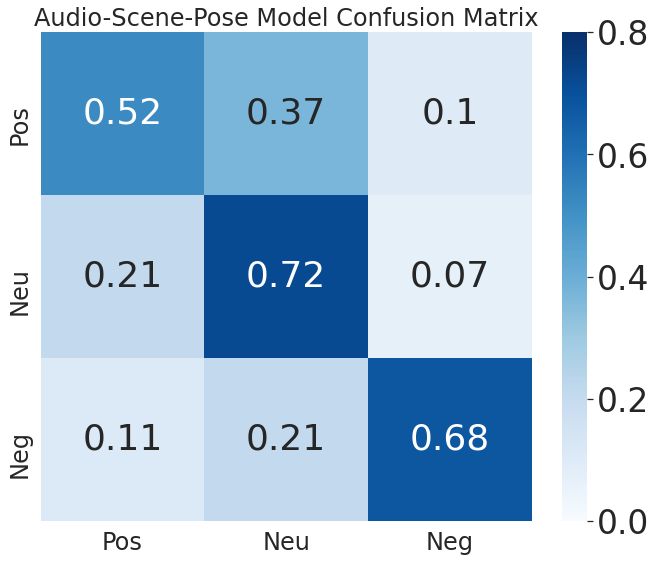

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene, Pose, and Audio")


plt.tick_params(labelsize=24)
plt.title("Audio-Scene-Pose Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues , vmin=0 , vmax=0.8)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")

In [0]:
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.661     0.523     0.584       302
     Neutral      0.571     0.718     0.636       280
    Negative      0.714     0.679     0.696       184

    accuracy                          0.632       766
   macro avg      0.649     0.640     0.639       766
weighted avg      0.641     0.632     0.630       766



## Remove the Scene!

In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifier import FaceClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', face_folder='train-final-fer' , labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
    face_classifier = FaceClassifier(face_folder, model_location='/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5', is_test=False)
    classifiers = [audio_classifier, pose_classifier , face_classifier] # frames_classifier
    
    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [0]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    "dense",
    #"concatenate_5",
    "bidirectional_1",
    "dense_27",
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose" , labels_file="Val_labels.txt")

X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")

print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames deter

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Customizing model by returning layer dense_27
Number of samples: 2661
Dim shapes: 
[32, 128, 8]
2661
2661
2661
AudioClassifier created with audio_folder = val-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = val-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = val-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a f

/content/cs231n-emotiw/src/generators/pose_generator.py:135: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((lx[i] - origin_x) / len_x)
/content/cs231n-emotiw/src/generators/pose_generator.py:136: RuntimeWarning: invalid value encountered in double_scalars
  x_new.append((ly[i] - origin_y) / len_y)


Customizing model by returning layer dense_27
Number of samples: 766
Dim shapes: 
[32, 128, 8]
766
766
766
(2661, 168)
(2661, 3)


In [0]:
!ls

In [0]:
# !mkdir ensemble-scene-pose-audio-face
# np.save("ensemble-scene-pose-audio-face/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face.zip ensemble-scene-pose-audio-face
# !cp ensemble-scene-pose-audio-face.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw

# !mkdir ensemble-scene-pose-audio-face-v2
# np.save("ensemble-scene-pose-audio-face-v2/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face-v2/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face-v2/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face-v2/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face-v2.zip ensemble-scene-pose-audio-face-v2
# !cp ensemble-scene-pose-audio-face-v2.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw


# !mkdir ensemble-scene-pose-audio-v1
# np.save("ensemble-scene-pose-audio-v1/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-v1/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-v1/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-v1/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-v1.zip ensemble-scene-pose-audio-v1
# !cp ensemble-scene-pose-audio-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw


!mkdir ensemble-pose-audio-face-v1
np.save("ensemble-pose-audio-face-v1/X_train.npy", X_train)
np.save("ensemble-pose-audio-face-v1/y_train.npy", y_train)
np.save("ensemble-pose-audio-face-v1/X_valid.npy", X_valid)
np.save("ensemble-pose-audio-face-v1/y_valid.npy", y_valid)
!zip -r ensemble-pose-audio-face-v1.zip ensemble-pose-audio-face-v1
!cp ensemble-pose-audio-face-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw


mkdir: cannot create directory ‘ensemble-pose-audio-face-v1’: File exists
  adding: ensemble-pose-audio-face-v1/ (stored 0%)
  adding: ensemble-pose-audio-face-v1/y_valid.npy (deflated 96%)
  adding: ensemble-pose-audio-face-v1/X_valid.npy (deflated 48%)
  adding: ensemble-pose-audio-face-v1/X_train.npy (deflated 48%)
  adding: ensemble-pose-audio-face-v1/y_train.npy (deflated 97%)


## Create FC Model (WITHOUT SCENE)





In [0]:
!ls

 data					     train-final-faces.zip
 drive					     train-final-fer
 ensemble-pose-audio-face-v1		     train-final-fer.zip
 ensemble-pose-audio-face-v1.zip	     train-final-frames
 ensemble-scene-pose-audio-v1		     train-final-frames.zip
 ensemble-scene-pose-audio-v1.zip	     train-final-pose
 fc-prediction				     train-final-pose.zip
 LICENSE				     Train_labels.txt
 models					     val-final-audio
 notebooks				     val-final-audio.zip
 README.md				     val-final-faces
 reports				     val-final-faces.zip
 requirements-predictions.txt		     val-final-fer
 requirements.txt			     val-final-fer.zip
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-frames
 src					     val-final-frames.zip
 train-final-audio			     val-final-pose
 train-final-audio.zip			     val-final-pose.zip
 train-final-faces			     Val_labels.txt


In [0]:
#!rm -rf ensemble-scene-pose-audio
#!cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio.zip .
#!unzip ensemble-scene-pose-audio.zip

X_train = np.load("ensemble-pose-audio-face-v1/X_train.npy")
y_train = np.load("ensemble-pose-audio-face-v1/y_train.npy")
X_valid = np.load("ensemble-pose-audio-face-v1/X_valid.npy")
y_valid = np.load("ensemble-pose-audio-face-v1/y_valid.npy")
X_train.shape

(2661, 168)

In [0]:
!pip install keras-tuner

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

MODEL_NAME = "ensemble-pose-audio-face-v1"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

def build_model(hp):
    Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
    checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1
    )

    def create_model(inputs):
        x = tf.keras.layers.Dense(hp.Int('units', min_value=8, max_value=128, step=8), activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                      loss = 'categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    inputs = tf.keras.Input(shape=(X_train.shape[1]))
    model = create_model(inputs)
    # model.summary()
    return model




In [0]:

from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='fc-prediction-ablate-scene',
    project_name='fc-prediction-ablate-scene'
)
tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_valid, y_valid),
             verbose=0)


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()

Epoch 1/30
84/84 [==============================] - ETA: 0s - loss: 0.6234 - accuracy: 0.7704
Epoch 00001: val_accuracy improved from -inf to 0.55744, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-pose-audio-face-v1/cp-0001.h5
84/84 [==============================] - 0s 5ms/step - loss: 0.6234 - accuracy: 0.7704 - val_loss: 1.0988 - val_accuracy: 0.5574
Epoch 2/30
84/84 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7884
Epoch 00002: val_accuracy improved from 0.55744 to 0.57050, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-pose-audio-face-v1/cp-0002.h5
84/84 [==============================] - 0s 4ms/step - loss: 0.5605 - accuracy: 0.7884 - val_loss: 1.0414 - val_accuracy: 0.5705
Epoch 3/30
63/84 [=====================>........] - ETA: 0s - loss: 0.5316 - accuracy: 0.8036
Epoch 00003: val_accuracy improved from 0.57050 to 0.57311, saving model to drive/My Drive/Machine-Learning

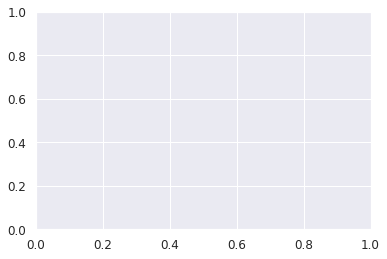

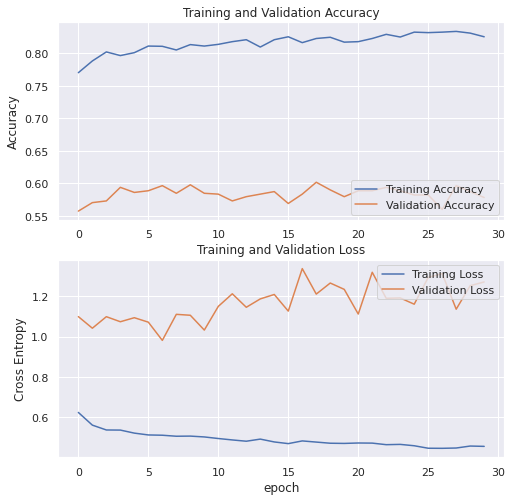

In [0]:

MODEL_NAME = "ensemble-pose-audio-face-v1"
Path(f"drive/My Drive/Machine-Learning-Projects/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/Machine-Learning-Projects/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(120, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.tick_params(labelsize=12)
sn.set(font_scale=1.0)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy' , fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss' , fontsize=12)
plt.xlabel('epoch')

plt.show()

#### Load Best Model to Perform Prediction

In [0]:
model = tf.keras.models.load_model("drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-pose-audio-face-v1/cp-0018.h5")

y_pred = model.predict(X_valid)

In [0]:
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_valid_labels

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [0]:
y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 2 2 2 3 1 2 2 3 3 3 2 2 1 3 3 1 3 2
 2 3 1 1 1 1 1 2 1 3 3 1 1 3 1 2 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 3 2 3 2 1 2 1 1 1 1 1 1 1 3 1 3 3 3 3 3 1 3 3 3 3 2 2
 3 3 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3
 3 3 1 3 2 1 3 1 1 1 1 1 1 3 1 1 1 1 1 1 3 3 3 3 3 3 3 3 2 2 2 2 2 3 2 3 3
 3 3 3 3 1 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 3 2
 1 2 2 3 3 3 3 3 2 3 3 2 2 3 3 3 3 3 2 2 2 2 2 2 3 2 3 3 3 3 2 3 3 2 2 2 2
 2 2 2 2 3 2 2 3 2 2 2 3 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2 3 2 2 2 2 2
 3 2 3 3 3 2 1 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2 1 2 2 2 3 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 1 2 2 2 2 2 1 1 1 3 2 2 2 3 3 3 3 1 3 3 3 2 2 2 2 3
 2 3 3 3 2 2 2 3 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 2 2 2 3 3 3 3 3 3 

Accuracy: 0.6018276762402088


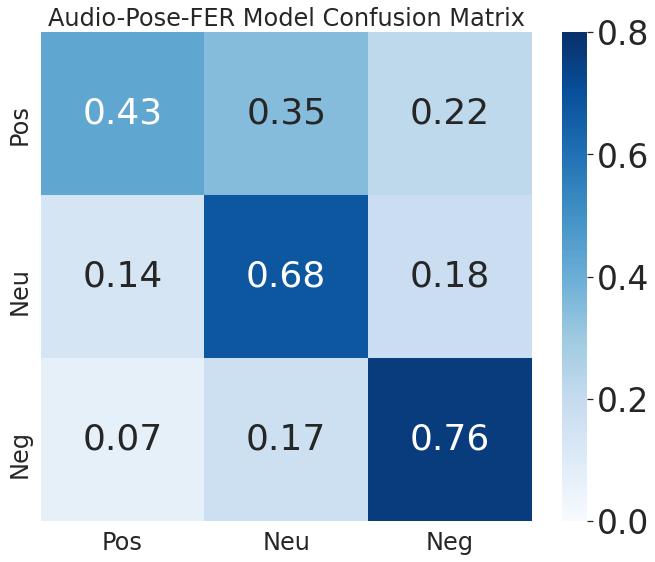

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene, Pose, and Audio")


plt.tick_params(labelsize=24)
plt.title("Audio-Pose-FER Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues , vmin=0 , vmax=0.8)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")

In [0]:
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.720     0.434     0.541       302
     Neutral      0.581     0.682     0.627       280
    Negative      0.545     0.755     0.633       184

    accuracy                          0.602       766
   macro avg      0.615     0.624     0.601       766
weighted avg      0.627     0.602     0.595       766



## Remove the Pose!

In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifier import FaceClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', face_folder='train-final-fer' , labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
    face_classifier = FaceClassifier(face_folder, model_location='/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5', is_test=False)
    classifiers = [audio_classifier, frames_classifier , face_classifier] # pose_classifier
    
    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [0]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    "dense",
    "concatenate_5",
    #"bidirectional_1",
    "dense_27",
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose" , labels_file="Val_labels.txt")

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
Customizing model by returning layer dense
Skipping unzipping files as input is a folder
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Cu

In [0]:
!ls

In [0]:
# !mkdir ensemble-scene-pose-audio-face
# np.save("ensemble-scene-pose-audio-face/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face.zip ensemble-scene-pose-audio-face
# !cp ensemble-scene-pose-audio-face.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw

# !mkdir ensemble-scene-pose-audio-face-v2
# np.save("ensemble-scene-pose-audio-face-v2/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face-v2/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face-v2/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face-v2/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face-v2.zip ensemble-scene-pose-audio-face-v2
# !cp ensemble-scene-pose-audio-face-v2.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw


# !mkdir ensemble-scene-pose-audio-v1
# np.save("ensemble-scene-pose-audio-v1/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-v1/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-v1/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-v1/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-v1.zip ensemble-scene-pose-audio-v1
# !cp ensemble-scene-pose-audio-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw


# !mkdir ensemble-pose-audio-face-v1
# np.save("ensemble-pose-audio-face-v1/X_train.npy", X_train)
# np.save("ensemble-pose-audio-face-v1/y_train.npy", y_train)
# np.save("ensemble-pose-audio-face-v1/X_valid.npy", X_valid)
# np.save("ensemble-pose-audio-face-v1/y_valid.npy", y_valid)
# !zip -r ensemble-pose-audio-face-v1.zip ensemble-pose-audio-face-v1
# !cp ensemble-pose-audio-face-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw

!mkdir ensemble-scene-audio-face-v1
np.save("ensemble-scene-audio-face-v1/X_train.npy", X_train)
np.save("ensemble-scene-audio-face-v1/y_train.npy", y_train)
np.save("ensemble-scene-audio-face-v1/X_valid.npy", X_valid)
np.save("ensemble-scene-audio-face-v1/y_valid.npy", y_valid)
!zip -r ensemble-scene-audio-face-v1.zip ensemble-scene-audio-face-v1
!cp ensemble-scene-audio-face-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw



mkdir: cannot create directory ‘ensemble-scene-audio-face-v1’: File exists
updating: ensemble-scene-audio-face-v1/ (stored 0%)
updating: ensemble-scene-audio-face-v1/y_valid.npy (deflated 96%)
updating: ensemble-scene-audio-face-v1/X_valid.npy (deflated 51%)
updating: ensemble-scene-audio-face-v1/X_train.npy (deflated 51%)
updating: ensemble-scene-audio-face-v1/y_train.npy (deflated 97%)


## Create FC Model (WITHOUT POSE)





In [0]:
!ls

 data					     train-final-faces.zip
 drive					     train-final-fer
 ensemble-pose-audio-face-v1		     train-final-fer.zip
 ensemble-pose-audio-face-v1.zip	     train-final-frames
 ensemble-scene-pose-audio-v1		     train-final-frames.zip
 ensemble-scene-pose-audio-v1.zip	     train-final-pose
 fc-prediction				     train-final-pose.zip
 LICENSE				     Train_labels.txt
 models					     val-final-audio
 notebooks				     val-final-audio.zip
 README.md				     val-final-faces
 reports				     val-final-faces.zip
 requirements-predictions.txt		     val-final-fer
 requirements.txt			     val-final-fer.zip
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-frames
 src					     val-final-frames.zip
 train-final-audio			     val-final-pose
 train-final-audio.zip			     val-final-pose.zip
 train-final-faces			     Val_labels.txt


In [0]:
#!rm -rf ensemble-scene-pose-audio
#!cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio.zip .
#!unzip ensemble-scene-pose-audio.zip

X_train = np.load("ensemble-scene-audio-face-v1/X_train.npy")
y_train = np.load("ensemble-scene-audio-face-v1/y_train.npy")
X_valid = np.load("ensemble-scene-audio-face-v1/X_valid.npy")
y_valid = np.load("ensemble-scene-audio-face-v1/y_valid.npy")
X_train.shape

(2661, 70)

In [0]:
!pip install keras-tuner

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

MODEL_NAME = "ensemble-scene-audio-face-v1"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

def build_model(hp):
    Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
    checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1
    )

    def create_model(inputs):
        x = tf.keras.layers.Dense(hp.Int('units', min_value=8, max_value=128, step=8), activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                      loss = 'categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    inputs = tf.keras.Input(shape=(X_train.shape[1]))
    model = create_model(inputs)
    # model.summary()
    return model




In [0]:

from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='fc-prediction-ablate-pose',
    project_name='fc-prediction-ablate-pose'
)
tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_valid, y_valid),
             verbose=0)


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()

Epoch 1/30
77/84 [==========================>...] - ETA: 0s - loss: 0.5320 - accuracy: 0.8011
Epoch 00001: val_accuracy improved from -inf to 0.60444, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-audio-face-v1/cp-0001.h5
84/84 [==============================] - 0s 5ms/step - loss: 0.5322 - accuracy: 0.8023 - val_loss: 0.9022 - val_accuracy: 0.6044
Epoch 2/30
64/84 [=====================>........] - ETA: 0s - loss: 0.4688 - accuracy: 0.8350
Epoch 00002: val_accuracy improved from 0.60444 to 0.61488, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-audio-face-v1/cp-0002.h5
84/84 [==============================] - 0s 3ms/step - loss: 0.4729 - accuracy: 0.8294 - val_loss: 0.9573 - val_accuracy: 0.6149
Epoch 3/30
82/84 [============================>.] - ETA: 0s - loss: 0.4643 - accuracy: 0.8205
Epoch 00003: val_accuracy improved from 0.61488 to 0.62141, saving model to drive/My Drive/Machine-Learni

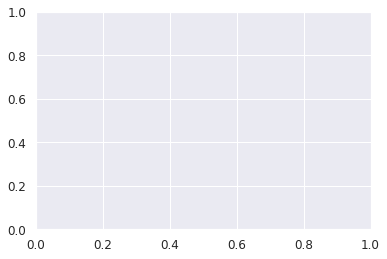

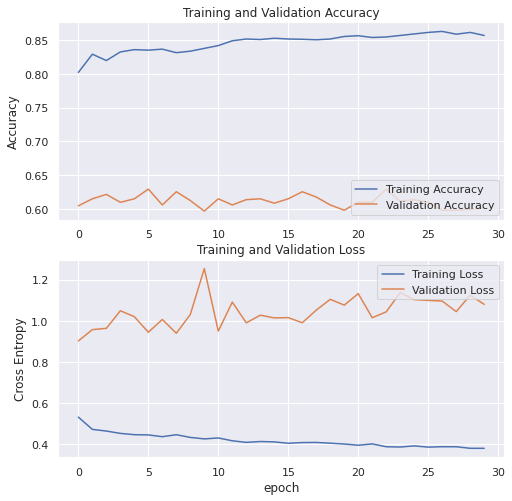

In [0]:

MODEL_NAME = "ensemble-scene-audio-face-v1"
Path(f"drive/My Drive/Machine-Learning-Projects/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/Machine-Learning-Projects/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(88, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.tick_params(labelsize=12)
sn.set(font_scale=1.0)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy' , fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss' , fontsize=12)
plt.xlabel('epoch')

plt.show()

#### Load Best Model to Perform Prediction

In [0]:
model = tf.keras.models.load_model("drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-audio-face-v1/cp-0006.h5")

y_pred = model.predict(X_valid)

In [0]:
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_valid_labels

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [0]:
y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 3 2 1 2 2 3 2 2 1 3 3 1 2 2
 2 3 1 1 1 1 1 1 1 3 3 1 1 1 1 2 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 3 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 3 3 1 3 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 2 2 3 3 3 3 2 2 2 2 3 3 2 3 3
 3 3 3 3 1 3 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 3 2
 3 2 2 3 3 3 3 3 2 3 3 1 2 3 3 3 3 3 2 2 2 2 1 1 3 1 3 3 3 3 2 3 3 1 1 2 1
 1 1 2 1 3 1 1 3 1 2 2 3 2 1 2 2 1 1 1 2 1 1 2 1 1 2 1 2 1 2 2 2 1 2 2 2 2
 3 2 1 1 3 2 1 2 2 2 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 2 3 3 1 1 1 1 1 1 3 2 2 2 2 3
 2 3 3 3 2 2 2 3 2 2 2 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 2 2 2 3 3 3 3 2 3 

Accuracy: 0.6292428198433421


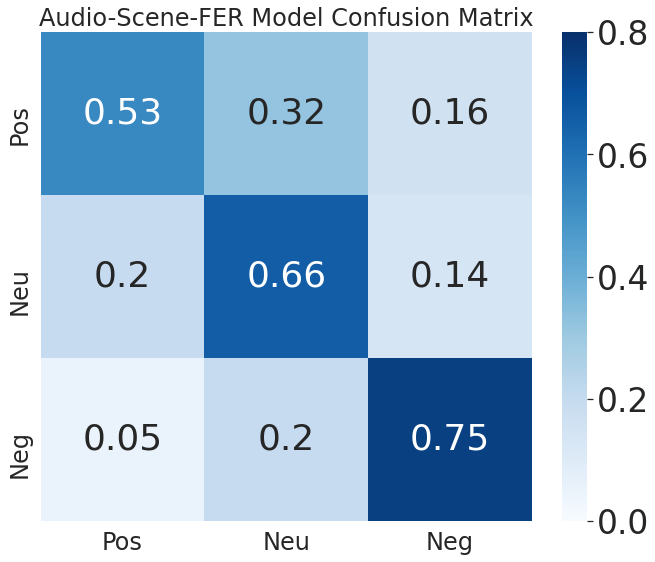

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene, Pose, and Audio")


plt.tick_params(labelsize=24)
plt.title("Audio-Scene-FER Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues , vmin=0 , vmax=0.8)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")

In [0]:
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.713     0.526     0.606       302
     Neutral      0.582     0.661     0.619       280
    Negative      0.613     0.750     0.675       184

    accuracy                          0.629       766
   macro avg      0.636     0.646     0.633       766
weighted avg      0.641     0.629     0.627       766



## Remove the Audio!

In [0]:
# Create the concatenated input layer to feed into FC

from src.classifiers.audio_classifier import AudioClassifier
from src.classifiers.frames_classifier import FramesClassifier
from src.classifiers.pose_classifier import PoseClassifier
from src.classifiers.face_classifier import FaceClassifier
from src.classifiers.utils import get_num_samples
import numpy as np

def run_classifier(layers_to_extract, audio_folder='train-final-audio', frames_folder='train-final-frames', pose_folder='train-final-pose', face_folder='train-final-fer' , labels_file="Train_labels.txt"):
    audio_classifier = AudioClassifier(audio_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5', is_test=False)
    frames_classifier = FramesClassifier(frames_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5', is_test=False)
    pose_classifier = PoseClassifier(pose_folder, model_location='https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5', is_test=False)
    face_classifier = FaceClassifier(face_folder, model_location='/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5', is_test=False)
    classifiers = [pose_classifier, frames_classifier , face_classifier] # audio_classifier
    
    sample_to_true_label = {}
    with open(labels_file) as f:
        l = 0
        for line in f:
            if l == 0:
                # Skip headers
                l += 1
                continue
            line_arr = line.split(" ")
            sample_to_true_label[line_arr[0].strip()] = int(line_arr[1].strip()) - 1 # subtract one to make labels from 0 to 2
            l += 1

    classifier_outputs = []
    classifier_samples = []
    classifier_dim_sizes = []
    output_dim_size = 0
    num_samples = 0
    sample_to_row = {}

    for i, classifier in enumerate(classifiers):
        output, samples = classifier.predict(layers_to_extract[i])
        output_dim_size += output.shape[1]
        classifier_dim_sizes.append(output.shape[1])
        num_samples = len(samples)
        classifier_outputs.append(output)
        classifier_samples.append(samples)


    X_train = np.zeros(shape=(num_samples, output_dim_size))
    y_train = []

    print(f"Number of samples: {num_samples}")
    print(f"Dim shapes: ")
    print(classifier_dim_sizes)

    for i, sample in enumerate(classifier_samples[0]):
        sample_to_row[sample] = i
        y_train.append(sample_to_true_label[sample])

    last_classifier_index = 0
    for c, output in enumerate(classifier_outputs):
        samples = classifier_samples[c]
        print(len(output))
        for i, row in enumerate(output):
            sample = samples[i]
            X_train[sample_to_row[sample], last_classifier_index:last_classifier_index+classifier_dim_sizes[c]] += row
        last_classifier_index += classifier_dim_sizes[c]

    return X_train, tf.keras.utils.to_categorical(y_train, num_classes=3)





In [0]:
import tensorflow as tf

# For each classifier, extract the specific desired layer 
# (refer to the model summary for the layer names)

layers_to_extract = [
    #"dense",
    "concatenate_5",
    "bidirectional_1",
    "dense_27",
]

prefix = "final"
if IS_TINY:
    prefix = "tiny"

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose" , labels_file="Val_labels.txt")

# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


# X_train, y_train = run_classifier(layers_to_extract, audio_folder=f"train-{prefix}-audio", frames_folder=f"train-{prefix}-frames", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
# X_valid, y_valid = run_classifier(layers_to_extract, audio_folder=f"val-{prefix}-audio", frames_folder=f"val-{prefix}-frames", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")

X_train, y_train = run_classifier(layers_to_extract, frames_folder=f"train-{prefix}-frames", pose_folder=f"train-{prefix}-pose", face_folder=f"train-{prefix}-fer" ,labels_file="Train_labels.txt")
X_valid, y_valid = run_classifier(layers_to_extract, frames_folder=f"val-{prefix}-frames", pose_folder=f"val-{prefix}-pose", face_folder=f"val-{prefix}-fer" , labels_file="Val_labels.txt")


print(X_train.shape)
print(y_train.shape)

AudioClassifier created with audio_folder = train-final-audio , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/openl3-cnn-lstm-tuned-lr.h5
FramesClassifier created with frames_folder = train-final-frames , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/scene-classifier-resnet-lstm-x3.h5
PoseClassifier created with pose_folder = train-final-pose , is_test = False , model_location = https://storage.googleapis.com/cs231n-emotiw/models/pose-classifier-64lstm-0.01reg.h5
load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = /content/drive/My Drive/Machine-Learning-Projects/cs231n-project/models/face-classifier-playground/cp-0001.h5
Skipping unzipping files as input is a folder
['2', '1', '3']
Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Customizing model by returning layer concatenate_5


ValueError: ignored

In [0]:
!ls

In [0]:
# !mkdir ensemble-scene-pose-audio-face
# np.save("ensemble-scene-pose-audio-face/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face.zip ensemble-scene-pose-audio-face
# !cp ensemble-scene-pose-audio-face.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw

# !mkdir ensemble-scene-pose-audio-face-v2
# np.save("ensemble-scene-pose-audio-face-v2/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-face-v2/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-face-v2/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-face-v2/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-face-v2.zip ensemble-scene-pose-audio-face-v2
# !cp ensemble-scene-pose-audio-face-v2.zip ../drive/'My Drive'/cs231n-project/datasets/emotiw


# !mkdir ensemble-scene-pose-audio-v1
# np.save("ensemble-scene-pose-audio-v1/X_train.npy", X_train)
# np.save("ensemble-scene-pose-audio-v1/y_train.npy", y_train)
# np.save("ensemble-scene-pose-audio-v1/X_valid.npy", X_valid)
# np.save("ensemble-scene-pose-audio-v1/y_valid.npy", y_valid)
# !zip -r ensemble-scene-pose-audio-v1.zip ensemble-scene-pose-audio-v1
# !cp ensemble-scene-pose-audio-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw


# !mkdir ensemble-pose-audio-face-v1
# np.save("ensemble-pose-audio-face-v1/X_train.npy", X_train)
# np.save("ensemble-pose-audio-face-v1/y_train.npy", y_train)
# np.save("ensemble-pose-audio-face-v1/X_valid.npy", X_valid)
# np.save("ensemble-pose-audio-face-v1/y_valid.npy", y_valid)
# !zip -r ensemble-pose-audio-face-v1.zip ensemble-pose-audio-face-v1
# !cp ensemble-pose-audio-face-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw

!mkdir ensemble-scene-pose-face-v1
np.save("ensemble-scene-pose-face-v1/X_train.npy", X_train)
np.save("ensemble-scene-pose-face-v1/y_train.npy", y_train)
np.save("ensemble-scene-pose-face-v1/X_valid.npy", X_valid)
np.save("ensemble-scene-pose-face-v1/y_valid.npy", y_valid)
!zip -r ensemble-scene-pose-face-v1.zip ensemble-scene-pose-face-v1
!cp ensemble-scene-pose-face-v1.zip ../drive/'My Drive/Machine-Learning-Projects'/cs231n-project/datasets/emotiw



  adding: ensemble-scene-pose-face-v1/ (stored 0%)
  adding: ensemble-scene-pose-face-v1/y_valid.npy (deflated 96%)
  adding: ensemble-scene-pose-face-v1/X_valid.npy (deflated 51%)
  adding: ensemble-scene-pose-face-v1/X_train.npy (deflated 51%)
  adding: ensemble-scene-pose-face-v1/y_train.npy (deflated 97%)


## Create FC Model (WITHOUT POSE)





In [0]:
!ls

 data					     train-final-faces.zip
 drive					     train-final-fer
 ensemble-pose-audio-face-v1		     train-final-fer.zip
 ensemble-pose-audio-face-v1.zip	     train-final-frames
 ensemble-scene-pose-audio-v1		     train-final-frames.zip
 ensemble-scene-pose-audio-v1.zip	     train-final-pose
 fc-prediction				     train-final-pose.zip
 LICENSE				     Train_labels.txt
 models					     val-final-audio
 notebooks				     val-final-audio.zip
 README.md				     val-final-faces
 reports				     val-final-faces.zip
 requirements-predictions.txt		     val-final-fer
 requirements.txt			     val-final-fer.zip
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-frames
 src					     val-final-frames.zip
 train-final-audio			     val-final-pose
 train-final-audio.zip			     val-final-pose.zip
 train-final-faces			     Val_labels.txt


In [0]:
#!rm -rf ensemble-scene-pose-audio
#!cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio.zip .
#!unzip ensemble-scene-pose-audio.zip

X_train = np.load("ensemble-scene-pose-face-v1/X_train.npy")
y_train = np.load("ensemble-scene-pose-face-v1/y_train.npy")
X_valid = np.load("ensemble-scene-pose-face-v1/X_valid.npy")
y_valid = np.load("ensemble-scene-pose-face-v1/y_valid.npy")
X_train.shape

(2661, 70)

In [0]:
!pip install keras-tuner

In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

MODEL_NAME = "ensemble-scene-pose-face-v1"

from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

def build_model(hp):
    Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
    checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
        period=1
    )

    def create_model(inputs):
        x = tf.keras.layers.Dense(hp.Int('units', min_value=8, max_value=128, step=8), activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(inputs)
        x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

        model = tf.keras.Model(inputs=inputs, outputs=x)
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                      loss = 'categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    inputs = tf.keras.Input(shape=(X_train.shape[1]))
    model = create_model(inputs)
    # model.summary()
    return model




In [0]:

from kerastuner.tuners import RandomSearch
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='fc-prediction-ablate-audio',
    project_name='fc-prediction-ablate-audio'
)
tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=30,
             validation_data=(X_valid, y_valid),
             verbose=0)


INFO:tensorflow:Oracle triggered exit


In [0]:
tuner.results_summary()

Epoch 1/30
81/84 [===========================>..] - ETA: 0s - loss: 0.5323 - accuracy: 0.8063
Epoch 00001: val_accuracy improved from -inf to 0.61227, saving model to drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-pose-face-v1/cp-0001.h5
84/84 [==============================] - 0s 5ms/step - loss: 0.5319 - accuracy: 0.8061 - val_loss: 0.8984 - val_accuracy: 0.6123
Epoch 2/30
76/84 [==========================>...] - ETA: 0s - loss: 0.4688 - accuracy: 0.8302
Epoch 00002: val_accuracy did not improve from 0.61227
84/84 [==============================] - 0s 4ms/step - loss: 0.4705 - accuracy: 0.8275 - val_loss: 0.9973 - val_accuracy: 0.5992
Epoch 3/30
78/84 [==========================>...] - ETA: 0s - loss: 0.4611 - accuracy: 0.8369
Epoch 00003: val_accuracy did not improve from 0.61227
84/84 [==============================] - 0s 4ms/step - loss: 0.4582 - accuracy: 0.8362 - val_loss: 1.0390 - val_accuracy: 0.6070
Epoch 4/30
64/84 [=====================>......

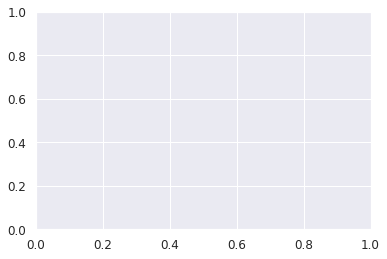

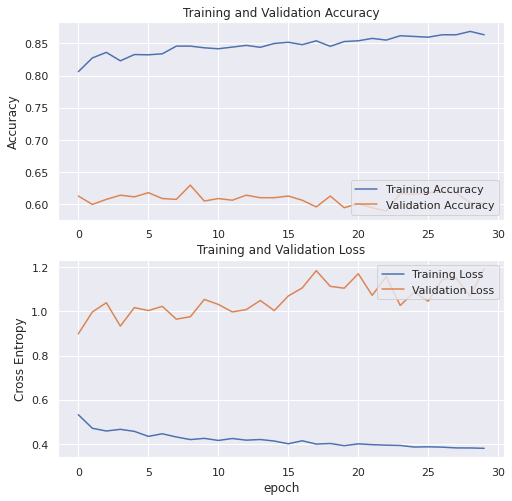

In [0]:

MODEL_NAME = "ensemble-scene-pose-face-v1"
Path(f"drive/My Drive/Machine-Learning-Projects/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/Machine-Learning-Projects/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(96, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.tick_params(labelsize=12)
sn.set(font_scale=1.0)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy' , fontsize=12)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss' , fontsize=12)
plt.xlabel('epoch')

plt.show()

#### Load Best Model to Perform Prediction

In [0]:
model = tf.keras.models.load_model("drive/My Drive/Machine-Learning-Projects/cs231n-project/models/ensemble-scene-pose-face-v1/cp-0009.h5")

y_pred = model.predict(X_valid)

In [0]:
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_valid_labels

array([3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 3, 2, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,

In [0]:
y_pred_labels = np.argmax(y_pred, axis=1) + 1
print(y_pred_labels)

[3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 1 2 2 2 3 3 2 1 3 2 3 2 2 1 1 3 1 2 2
 2 3 1 1 1 1 1 1 1 3 1 1 1 1 1 2 1 1 1 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 3 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 3 2 2 2 2
 2 2 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2 3 3 3 3 2 2 2 3 3 3 2 3 1
 3 3 3 3 1 3 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 3 2 1 1 2 2 2 2 2 3 2
 3 2 2 3 3 3 3 3 2 3 3 1 2 3 3 3 3 3 2 2 2 2 1 1 3 1 3 3 3 3 2 3 3 1 1 2 1
 1 1 2 1 3 1 1 3 1 2 2 3 2 1 2 2 1 1 1 2 1 1 2 1 1 2 1 2 1 2 2 2 1 2 2 2 2
 1 2 1 1 3 1 1 1 2 2 2 1 2 2 1 1 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 3 2 3 2 3 3
 2 3 3 3 2 2 2 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3
 3 3 3 2 2 2 3 3 3 3 3 3 

Accuracy: 0.6292428198433421


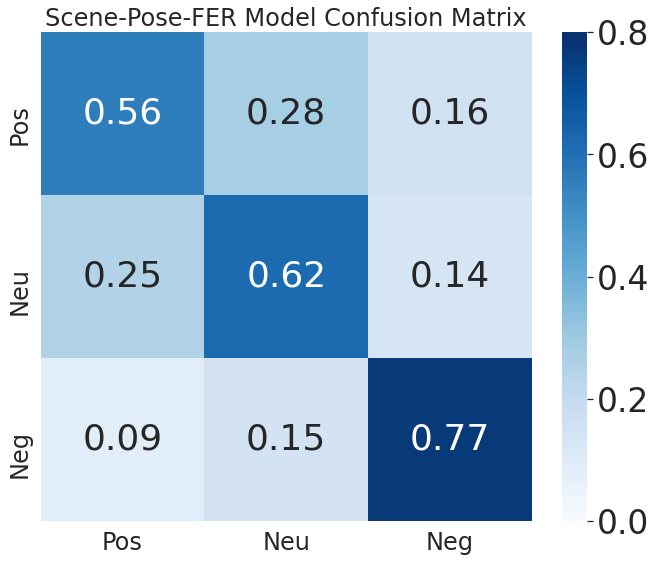

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene, Pose, and Audio")


plt.tick_params(labelsize=24)
plt.title("Scene-Pose-FER Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues , vmin=0 , vmax=0.8)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")

In [0]:
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

              precision    recall  f1-score   support

    Positive      0.664     0.556     0.605       302
     Neutral      0.607     0.618     0.612       280
    Negative      0.618     0.766     0.684       184

    accuracy                          0.629       766
   macro avg      0.630     0.647     0.634       766
weighted avg      0.632     0.629     0.627       766



## FC Classifier ALL

> Indented block



In [0]:
!ls

 data					     train-final-faces
 drive					     train-final-faces.zip
 ensemble-scene-pose-audio		     train-final-fer
 ensemble-scene-pose-audio-face		     train-final-fer.zip
 ensemble-scene-pose-audio-face.zip	     train-final-frames
 ensemble-scene-pose-audio.zip		     train-final-frames.zip
 ensemble-scenex2-pose-audio		     train-final-pose
 ensemble-scenex2-pose-audio.zip	     train-final-pose.zip
 fc-prediction				     Train_labels.txt
 LICENSE				     val-final-audio
 models					     val-final-audio.zip
 notebooks				     val-final-faces
 README.md				     val-final-faces.zip
 reports				     val-final-fer
 requirements-predictions.txt		     val-final-fer.zip
 requirements.txt			     val-final-frames
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-frames.zip
 src					     val-final-pose
 train-final-audio			     val-final-pose.zip
 train-final-audio.zip			     Val_labels.txt


In [0]:
# !rm -rf ensemble-scene-pose-audio-face-v2
# !cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scene-pose-audio-face-v2.zip .
# !unzip ensemble-scene-pose-audio-face-v2.zip

X_train = np.load("ensemble-scene-pose-audio-face-v2/X_train.npy")
y_train = np.load("ensemble-scene-pose-audio-face-v2/y_train.npy")
X_valid = np.load("ensemble-scene-pose-audio-face-v2/X_valid.npy")
y_valid = np.load("ensemble-scene-pose-audio-face-v2/y_valid.npy")
X_train.shape

(2661, 198)

Epoch 1/30
70/84 [========================>.....] - ETA: 0s - loss: 0.5175 - accuracy: 0.8027
Epoch 00001: val_accuracy improved from -inf to 0.59399, saving model to drive/My Drive/cs231n-project/models/ensemble-fc-v3-face-v2/cp-0001.h5
84/84 [==============================] - 0s 4ms/step - loss: 0.5169 - accuracy: 0.8031 - val_loss: 1.0100 - val_accuracy: 0.5940
Epoch 2/30
66/84 [======================>.......] - ETA: 0s - loss: 0.4628 - accuracy: 0.8210
Epoch 00002: val_accuracy improved from 0.59399 to 0.61227, saving model to drive/My Drive/cs231n-project/models/ensemble-fc-v3-face-v2/cp-0002.h5
84/84 [==============================] - 0s 3ms/step - loss: 0.4605 - accuracy: 0.8226 - val_loss: 1.0223 - val_accuracy: 0.6123
Epoch 3/30
70/84 [========================>.....] - ETA: 0s - loss: 0.4356 - accuracy: 0.8313
Epoch 00003: val_accuracy improved from 0.61227 to 0.62924, saving model to drive/My Drive/cs231n-project/models/ensemble-fc-v3-face-v2/cp-0003.h5
84/84 [===============

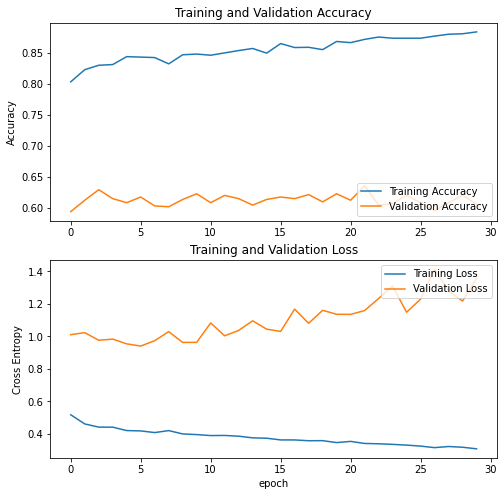

In [0]:

MODEL_NAME = "ensemble-fc-v3-face-v2"
Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(48, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model = tf.keras.models.load_model("drive/My Drive/cs231n-project/models/ensemble-fc-v3-face-v2/cp-0022.h5")

y_pred = model.predict(X_valid)
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_pred_labels = np.argmax(y_pred, axis=1) + 1


Accuracy: 0.6357702349869452
              precision    recall  f1-score   support

    Positive      0.709     0.500     0.586       302
     Neutral      0.598     0.654     0.625       280
    Negative      0.619     0.832     0.710       184

    accuracy                          0.636       766
   macro avg      0.642     0.662     0.640       766
weighted avg      0.647     0.636     0.630       766



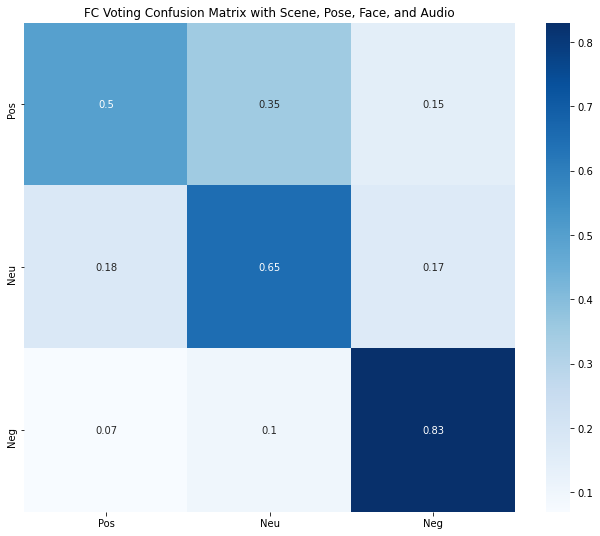

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt
import tensorflow

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene, Pose, Face, and Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

## FC Classifier (WITH DOUBLE SCENE)

In [0]:
!ls

 data					     train-final-faces
 drive					     train-final-faces.zip
 ensemble-scene-pose-audio		     train-final-fer
 ensemble-scene-pose-audio-face		     train-final-fer.zip
 ensemble-scene-pose-audio-face.zip	     train-final-frames
 ensemble-scene-pose-audio.zip		     train-final-frames.zip
 ensemble-scenex2-pose-audio		     train-final-pose
 ensemble-scenex2-pose-audio.zip	     train-final-pose.zip
 fc-prediction				     Train_labels.txt
 LICENSE				     val-final-audio
 models					     val-final-audio.zip
 notebooks				     val-final-faces
 README.md				     val-final-faces.zip
 reports				     val-final-fer
 requirements-predictions.txt		     val-final-fer.zip
 requirements.txt			     val-final-frames
'Screen Shot 2020-05-26 at 8.53.32 PM.png'   val-final-frames.zip
 src					     val-final-pose
 train-final-audio			     val-final-pose.zip
 train-final-audio.zip			     Val_labels.txt


In [0]:
# !rm -rf ensemble-scenex2-pose-audio
# !cp ../drive/'My Drive'/cs231n-project/datasets/emotiw/ensemble-scenex2-pose-audio.zip .
# !unzip ensemble-scenex2-pose-audio.zip

X_train = np.load("ensemble-scenex2-pose-audio/X_train.npy")
y_train = np.load("ensemble-scenex2-pose-audio/y_train.npy")
X_valid = np.load("ensemble-scenex2-pose-audio/X_valid.npy")
y_valid = np.load("ensemble-scenex2-pose-audio/y_valid.npy")
X_train.shape

(2661, 260)

Epoch 1/30
79/84 [===========================>..] - ETA: 0s - loss: 0.6713 - accuracy: 0.7551
Epoch 00001: val_accuracy improved from -inf to 0.61619, saving model to drive/My Drive/cs231n-project/models/ensemble-fc-v3-scenex2/cp-0001.h5
84/84 [==============================] - 0s 5ms/step - loss: 0.6680 - accuracy: 0.7576 - val_loss: 0.9056 - val_accuracy: 0.6162
Epoch 2/30
76/84 [==========================>...] - ETA: 0s - loss: 0.4944 - accuracy: 0.8273
Epoch 00002: val_accuracy did not improve from 0.61619
84/84 [==============================] - 0s 4ms/step - loss: 0.4981 - accuracy: 0.8253 - val_loss: 0.9775 - val_accuracy: 0.6110
Epoch 3/30
82/84 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.8331
Epoch 00003: val_accuracy did not improve from 0.61619
84/84 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.8309 - val_loss: 0.9310 - val_accuracy: 0.6136
Epoch 4/30
83/84 [============================>.] - ETA: 0s - loss: 0.4685 - 

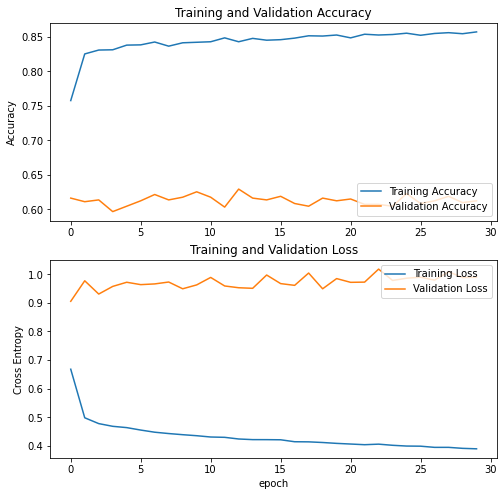

In [0]:

MODEL_NAME = "ensemble-fc-v3-scenex2"
Path(f"drive/My Drive/cs231n-project/models/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy',
    period=1
)

def create_model(inputs):
    x = tf.keras.layers.Dense(32, activation='relu')(inputs)
    x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

inputs = tf.keras.Input(shape=(X_train.shape[1]))
model = create_model(inputs)

import pickle
history = model.fit(
          x=X_train,
          y=y_train,
          epochs=30,
          callbacks=[cp_callback],
          validation_data=(X_valid, y_valid)
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model = tf.keras.models.load_model("drive/My Drive/cs231n-project/models/ensemble-fc-v3-scenex2/cp-0013.h5")

y_pred = model.predict(X_valid)
y_valid_labels = np.argmax(y_valid, axis=1) + 1
y_pred_labels = np.argmax(y_pred, axis=1) + 1


Accuracy: 0.6292428198433421
              precision    recall  f1-score   support

    Positive      0.695     0.513     0.590       302
     Neutral      0.581     0.679     0.626       280
    Negative      0.634     0.745     0.685       184

    accuracy                          0.629       766
   macro avg      0.637     0.645     0.634       766
weighted avg      0.639     0.629     0.626       766



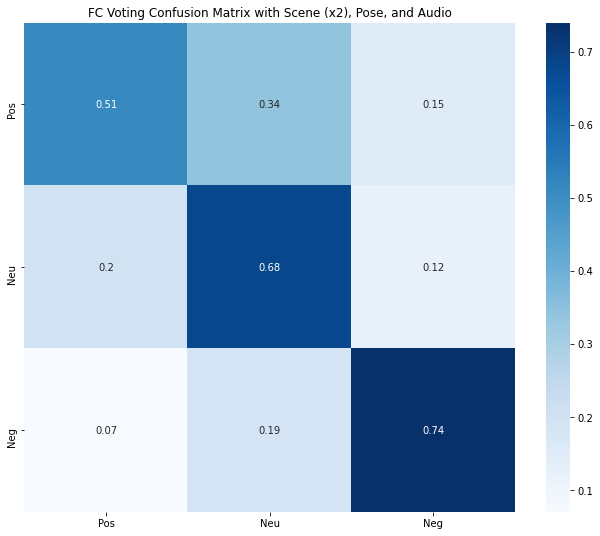

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.title("FC Voting Confusion Matrix with Scene (x2), Pose, and Audio")
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

### Figure out why faces is bad?

In [0]:
!ls val-final-fer

faces-fer-X.npy  faces-fer-Y.npy


In [0]:
fer_x = np.load("train-final-fer/faces-fer-X.npy")
fer_y = np.load("train-final-fer/faces-fer-Y.npy")

In [0]:
index = 0

In [0]:
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

with np.printoptions(precision=3, suppress=True):
    print(fer_x[index,:,0:7])
    print(fer_x[index,:,7:14])
    print(fer_x[index,:,14:21])
np.argmax(fer_x[index,:,14:21], axis=1)

[[0.168 0.    0.699 0.101 0.18  0.016 0.162]
 [0.222 0.    0.29  0.725 0.108 0.051 0.508]
 [0.466 0.    0.453 0.047 0.004 0.024 0.005]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.583 0.    0.768 0.016 0.022 0.056 0.019]
 [0.315 0.    0.24  0.636 0.088 0.017 0.414]
 [0.614 0.    0.027 0.252 0.011 0.004 0.092]
 [0.407 0.    0.583 0.009 0.    0.001 0.   ]
 [0.729 0.002 0.446 0.735 0.026 0.098 0.012]
 [0.857 0.    0.868 0.095 0.051 0.121 0.013]
 [0.752 0.    0.299 0.009 0.004 0.004 0.001]
 [0.386 0.    0.902 0.742 0.024 0.098 0.017]]
[[0.082 0.    0.471 0.059 0.052 0.005 0.006]
 [0.093 0.    0.034 0.063 0.007 0.008 0.025]
 [0.466 0.    0.453 0.047 0.004 0.024 0.005]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.119 0.    0.403 0.008 0.005 0.001 0.001]
 [0.076 0.    0.167 0.001 0.013 0.004 0.039]
 [0.614 0.    0.027 0.252 0.011 0.004 0.092]
 [0.407 0.    0.583 0.009 0.    0.001 0.   ]
 [0.08  0.    0.168 0.013 0.003 0.    0.   ]
 [0.083 0.    0.108 0.002 0.001 0.    0.001]
 [0.7   0

array([2, 3, 0, 0, 2, 3, 0, 2, 0, 2, 0, 2])

In [0]:
# Num people
fer_x[index, :, -1]

array([2., 3., 1., 0., 2., 3., 1., 1., 4., 4., 2., 4.])

In [0]:
fer_y[index]

array(['204_1', '2'], dtype='<U8')

In [0]:
!cat Train_labels.txt | grep "204_1"

204_1 3
204_10 3
204_11 3
204_12 3
204_13 3


In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open("/content/drive/My Drive/cs231n-project/datasets/emotiw/train/" + fer_y[index, 0] + '.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [0]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import Normalizer
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path


class FaceClassifierV2:
  """
  Classifies sentiment based on facial expressions extracted from videos
  """
  def __init__(self, face_folder, is_test, model_location=None, batch_size=32):
      """
      @param face_folder   The folder where the arrays of processed facial expression embeddings are stored. If
                            ends with .zip, this should be a single zip
                            file containing the embeddings. Paths can either be accessed by a local
                            folder or a GDrive mounted path.
      @param model_location The pre-trained model to perform predictions of labels
      @param is_test        If set to True, we assume that we are testing . If false, the evaluate
                            function will return a score.
      @param batch_size     The batch size used to feed into the model evaluation
      """
      self.face_folder = face_folder
      self.is_test = is_test
      self.model_location = model_location
      self.batch_size = batch_size

      self.load_data()

      print(f"FacesClassifier created with face_folder = {face_folder} , is_test = {is_test} , model_location = {model_location}")
      if self.model_location is not None:
          if "https://" in self.model_location or "http://" in self.model_location:
              downloaded_model_path = tf.keras.utils.get_file("face-classifier", self.model_location)
              self.model = load_model(downloaded_model_path)
          else:
              self.model = load_model(self.model_location)
      else:
          self.model = self.init_model()

  def load_data(self):
      print("load data")
      # self.X1 = np.load(os.path.join(self.face_folder, "faces-fer-X.npy"))[:, :, 0:7]
      # self.X2 = np.load(os.path.join(self.face_folder, "faces-fer-X.npy"))[:, :, -1]
      # self.X = np.concatenate((self.X1, np.expand_dims(self.X2, axis=2)), axis=2)
      # print(self.X.shape)
      self.X = np.load(os.path.join(self.face_folder, "faces-fer-X.npy"))

      if os.path.exists(os.path.join(self.face_folder, "faces-fer-Y.npy")):
          self.Y = np.load(os.path.join(self.face_folder, "faces-fer-Y.npy")).astype(int)[:, 1]
          self.Y = tf.keras.utils.to_categorical(self.Y, num_classes=3)

  def predict(self, layer=None):
      if layer is not None:
          print(f"Customizing model by returning layer {layer}")
          model = tf.keras.models.Model(self.model.input, self.model.get_layer(layer).output)
      else:
          model = self.model
      path = os.path.join(self.face_folder, "faces-fer-Y.npy")
      y = np.load(path, allow_pickle=True)
      samples = map(lambda x: str(x), y[:, 0])
      return model.predict(self.X, batch_size=self.batch_size), list(samples)

  def summary(self):
      self.model.summary()

  def load_model(self, best_model_filepath):
      return load_model(best_model_filepath)

  # Inputs (N,22): min, max, mean of all facial hidden features, # of faces in frame
  # Ouputs (3): frame sentiment
  def init_model(self):
      def create_model(inputs):
          x = inputs
          x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(inputs)
          x = tf.keras.layers.Dense(8, activation='relu')(x)
          x = tf.keras.layers.Dense(3, activation='softmax')(x)

          # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

          optimizer = tf.keras.optimizers.Adam(lr=0.005)
          model = tf.keras.Model(inputs=inputs, outputs=x)
          model.compile(optimizer=optimizer,
                        loss = 'categorical_crossentropy',
                        metrics=['accuracy'])
          return model

      inputs = tf.keras.Input(shape=(self.X.shape[1], self.X.shape[2]))
      model = create_model(inputs)
      return model

  def train(self, faces_val_folder, epochs=20, save_path=None):
      """
      - Outputs
        1. Trained model -- saves the model as an .h5 file to the specified path
      """
      # self.X_val1 = np.load(os.path.join(faces_val_folder, "faces-fer-X.npy"))[:, :, 0:7]
      # self.X_val2 = np.load(os.path.join(faces_val_folder, "faces-fer-X.npy"))[:, :, -1]
      # self.X_val = np.concatenate((self.X_val1, np.expand_dims(self.X_val2, axis=2)), axis=2)

      self.X_val = np.load(os.path.join(faces_val_folder, "faces-fer-X.npy")).astype(int)
      self.Y_val = np.load(os.path.join(faces_val_folder, "faces-fer-Y.npy")).astype(int)[:, 1]
      self.Y_val = tf.keras.utils.to_categorical(self.Y_val, num_classes=3)

      es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)
      mc = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True)

      history = self.model.fit(self.X, self.Y, 
                                epochs=epochs,
                                batch_size=self.batch_size, 
                                callbacks=[es, mc],
                                validation_data=(self.X_val, self.Y_val))

      return self.model, history


In [0]:
from pathlib import Path
import matplotlib.pyplot as plt

MODEL_NAME = "face-classifier-playground"
save_path = "/content/drive/My Drive/cs231n-project/models/" + MODEL_NAME + "/cp-{epoch:04d}.h5"
Path(save_path).mkdir(parents=True, exist_ok=True)

face_classifier = FaceClassifierV2("train-final-fer", is_test=False)

_, history = face_classifier.train("val-final-fer", epochs=20, save_path=save_path)




load data
FacesClassifier created with face_folder = train-final-fer , is_test = False , model_location = None
Epoch 1/20
80/84 [===========================>..] - ETA: 0s - loss: 1.0947 - accuracy: 0.3578
Epoch 00001: val_loss improved from inf to 1.10639, saving model to /content/drive/My Drive/cs231n-project/models/face-classifier-playground/cp-0001.h5
84/84 [==============================] - 1s 17ms/step - loss: 1.0949 - accuracy: 0.3596 - val_loss: 1.1064 - val_accuracy: 0.4125
Epoch 2/20
81/84 [===========================>..] - ETA: 0s - loss: 1.0814 - accuracy: 0.4059
Epoch 00002: val_loss did not improve from 1.10639
84/84 [==============================] - 1s 7ms/step - loss: 1.0822 - accuracy: 0.4059 - val_loss: 1.1160 - val_accuracy: 0.3995
Epoch 3/20
77/84 [==========================>...] - ETA: 0s - loss: 1.0690 - accuracy: 0.4030
Epoch 00003: val_loss did not improve from 1.10639
84/84 [==============================] - 1s 7ms/step - loss: 1.0698 - accuracy: 0.4059 - val_l

In [0]:
len(history.history["accuracy"])

30

In [0]:
model = tf.keras.models.load_model("/content/drive/My Drive/cs231n-project/models/face-classifier-playground/cp-0001.h5")

X_valid = np.load("val-final-fer/faces-fer-X.npy")
y_valid = np.array(np.load("val-final-fer/faces-fer-Y.npy")[:, 1], dtype=int) + 1

y_pred = model.predict(X_valid)
y_valid_labels = y_valid
y_pred_labels = np.argmax(y_pred, axis=1) + 1



Accuracy: 0.4007832898172324
              precision    recall  f1-score   support

    Positive      0.426     0.096     0.157       302
     Neutral      0.418     0.764     0.540       280
    Negative      0.344     0.348     0.346       184

    accuracy                          0.401       766
   macro avg      0.396     0.403     0.348       766
weighted avg      0.404     0.401     0.342       766



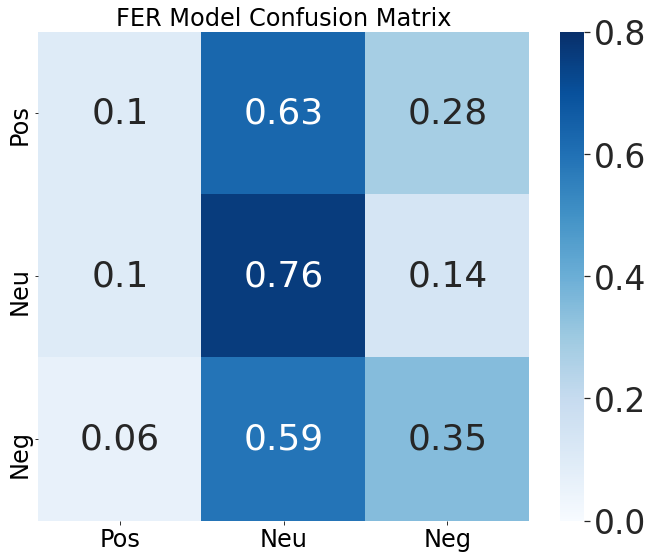

In [0]:
from sklearn import metrics 
import pandas as pd
import seaborn as sn
cm=metrics.confusion_matrix(y_valid_labels,y_pred_labels)
import matplotlib.pyplot as plt

classes=['Pos' , 'Neu' , 'Neg'] 
y_pred_final , y_true_final = y_pred_labels - 1 , y_valid_labels - 1
con_mat = tensorflow.math.confusion_matrix(labels=y_true_final, predictions=y_pred_final).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)

figure = plt.figure(figsize=(11, 9))
plt.tick_params(labelsize=24)
plt.title("FER Model Confusion Matrix", fontsize=24)
sn.set(font_scale=3.0)
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, vmin=0, vmax=0.8)


accuracy = (y_pred_labels == y_valid_labels).mean()
print(f"Accuracy: {accuracy}")
from sklearn.metrics import classification_report
target_names = ["Positive" , "Neutral" , "Negative"]
print(classification_report(y_valid_labels, y_pred_labels, target_names=target_names, digits=3))

